In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import pandas as pd
import imageio
# imageio.plugins.ffmpeg.download()

%matplotlib inline
%matplotlib notebook

In [2]:
# Some notable stuff for me


# print(img.shape, img.dtype, np.max(img), np.min(img))

# rchan[:, :, [1, 2]] = 0

# cv2.polylines(image, np.int32([src_pts]), True, (0, 0, 255), 1)

# x = np.array([6, 2])
# print((x.astype(np.float)).dtype)
# print((np.float(x)).dtype)


# r, theta = cart2polar(rover_perspect_x, rover_perspect_y)
# avg_angle = np.mean(theta)
# arrow_length = 100
# arrow_dx = arrow_length * np.cos(avg_angle)
# arrow_dy = arrow_length * np.sin(avg_angle)

# ax2[1].arrow(0, 0, arrow_dx, arrow_dy, length_includes_head = 100,
#              shape = 'full', color = 'red', zorder = 2, width = 2, head_width=10)

In [3]:
# Function for thresholding the rover front cam image in order to define navigable terrain i.e. The (light-colored) ground

def color_thresh(img, rgb_thresh= (0, 0, 0)):
    
    color_select = np.zeros_like(img[:, :, 0])
    rchan = img[:, :, 0] >= rgb_thresh[0] # red channel indices that are over thresh
    gchan = img[:, :, 1] >= rgb_thresh[1]
    bchan = img[:, :, 2] >= rgb_thresh[2]
    
    above_thresh_indices = rchan & gchan & bchan
    
    color_select[above_thresh_indices] = 1
    
    return color_select


# Function for determining non-navigable terrain by thresholding LOWER than the upper function,
# but it did not work well i do not know why.

def color_thresh_obstacles(img, rgb_thresh = (0, 0, 0)):
    
    color_select = np.zeros_like(img[:, :, 0])
    rchan = (img[:, :, 0] <= rgb_thresh[0])
    gchan = (img[:, :, 1] <= rgb_thresh[1])
    bchan = (img[:, :, 2] <= rgb_thresh[2]) 
    
    thresh_indices = rchan & gchan & bchan
    
    color_select[thresh_indices] = 1
    
    return color_select


# Inspired by the opencv tutorials link provided in the Udacity lectures, this function detects yellow colors
# by converting to the HSV colorspace and thresholding for yellow, a mask is then applied to extract only the ROI

def detect_yellow(img):
    
    copy = np.copy(img)
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([20,100,100])
    upper_yellow = np.array([30,255,255])
    yellow_mask = cv2.inRange(hsv_img, lower_yellow, upper_yellow)
    
    masked_rgb_img = cv2.bitwise_and(copy, copy, mask = yellow_mask)
    gray = cv2.cvtColor(masked_rgb_img, cv2.COLOR_RGB2GRAY)
    yellow_indices = gray[:, :] > 100
    
    binary_img = np.zeros_like(copy[:, :, 0])
    binary_img[yellow_indices] = 1
    
    # output_img = color_thresh(masked_img, rgb_thresh= (0, 0, 0))
    # match_result = cv2.matchTemplate(output_img, template, cv2.TM_CCORR_NORMED)
    # min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match_result)
    # cv2.circle(copy, (max_loc[0], max_loc[1]), 30, (255, 0, 0), 10)
    # cv2.rectangle(copy, (max_loc[0], max_loc[1]), (max_loc[0] + template.shape[1], max_loc[1] + template.shape[0]), (0, 255, 0), 2)
    return binary_img


# Function to detect yellow rocks, perform perspective transform, and convert the sample coords to world coords for 
# mapping purposes

def yellow_rock_world(img, rover_world_x, rover_world_y, yaw, scale, world_size):
    
    binary_img_rover_front_cam = detect_yellow(img)
    warped_rock = perspect_transform(binary_img_rover_front_cam, src_pts, dst_pts)
    rock_rover_coords_x, rock_rover_coords_y = rover_coords(warped_rock)
    rock_world_x, y_world_x = rover2world(rock_rover_coords_x, rock_rover_coords_y,
                                          rover_world_x, rover_world_y, yaw, scale, world_size)
    
    return rock_world_x, y_world_x

In [4]:

# Perspect transform as the one explained in the lectures

def perspect_transform(img, src_pts, dst_pts):
    
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    
    return warped

In [5]:
# Same functions as in the lectures to convert from front camera view to robot perspective
# for both navigable and non-navigable terrain, just different variable names (easier for me)

def rover_coords(binary_img_for_shape_purposes):
    
    y_pix_front_cam, x_pix_front_cam = binary_img_for_shape_purposes.nonzero()
    
    x_rover = (-y_pix_front_cam + binary_img_for_shape_purposes.shape[0]).astype(np.float)
    y_rover = (-x_pix_front_cam + binary_img_for_shape_purposes.shape[1] / 2).astype(np.float)
    
    return x_rover, y_rover


def rover_coords_obstacles(binary_img_for_shape_purposes):
    
    # Bottom offset is hard-coded----Change later
    ypos, xpos = np.where(binary_img_for_shape_purposes[:-5, :] == 1)
 
    x_pixel = -(ypos - binary_img_for_shape_purposes.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img_for_shape_purposes.shape[1]/2 ).astype(np.float)
    
    return x_pixel, y_pixel

In [6]:
# Coordinate transformation functions as explained and implemented in the lectures

def coords_rotate(x_rover, y_rover, yaw):
    
    yaw_rad = yaw * np.pi/180.0
    
    x_rotated = (x_rover * np.cos(yaw_rad)) - (y_rover * np.sin(yaw_rad))
    y_rotated = (x_rover * np.sin(yaw_rad)) + (y_rover * np.cos(yaw_rad))
    
    return x_rotated, y_rotated

def coords_translate(x_rover, y_rover, rover_x_position, rover_y_position, scale):
    
    x_translated = np.int_((x_rover / scale) + rover_x_position)
    y_translated = np.int_((y_rover / scale) + rover_y_position)
    
    return x_translated, y_translated

"""
Keep in mind, however, the scale associated with pixels
in rover space versus world space. If, for example,
as suggested in the previous exercise, 
you have mapped pixels in rover space such
that each represents 0.1 x 0.1 m, and in your
world map (as will be the case in the project) each pixel is 1 x 1 m,
then you need to divide your rover space pixel values by 10 before 
mapping to world space. In that case, assuming the x and y position
of the rover are given as xpos and ypos:
"""
# From robot-relative coordinate system to world coords for mapping

def rover2world(x_rover, y_rover, rover_x_position, rover_y_position, yaw, scale, world_size):
    
    # rover front camera pixels ---> rover perspective ---> rotated ---> scaled ---> translated
    x_rotated, y_rotated = coords_rotate(x_rover, y_rover, yaw)
    x_scaled_and_translated_after_rotated, y_scaled_and_translated_after_rotated = coords_translate(x_rotated
                                                                              , y_rotated, rover_x_position, 
                                                                              rover_y_position, scale)
    
    # Clipping
    x_world = np.clip(x_scaled_and_translated_after_rotated, 0, world_size - 1) # Remember the -1 
    y_world = np.clip(y_scaled_and_translated_after_rotated, 0, world_size - 1)
    
    return x_world, y_world

In [7]:
# Cartesian to Polar coordinate system conversion for detecting navigable angles and their respective distances
def cart2polar(x_pix, y_pix):
    
    r = np.sqrt(x_pix**2 + y_pix**2)
    theta = np.arctan2(y_pix, x_pix)
    
    return r, theta

In [8]:
# Rover object, same one from the lectures
def RoverState():
    def __init__(self):
        
        self.start_time = None # To record the start time of navigation
        self.total_time = None # To record elapsed time of navigation
        self.img = None        # Current front camera img
        self.pos = None        # Current position of rover (x, y)
        self.yaw = None        # Current Yaw angle
        self.pitch = None      # Current Pitch angle
        self.roll = None       # Current Roll angle
        self.vel = 0           # Current velocity
        self.steer = 0         # Current steering angle
        self.throttle = 0      # Current throttle value
        self.brake = 0         # Current brake value
        self.nav_angles = None # List of angles for navigable terrain pixels
        self.nav_dists = None  # List of distances for navigable terrain pixels # i think according to nav_angles, respectively
        self.ground_truth = ground_truth_3d    # Ground truth Worldmap
        self.mode = 'forward'  # Current mode. Can be 'forward' or 'stop'
        self.throttle_set = 0.2 # Throttle setting/value when accelerating
        self.brake_set = 10    # Brake setting/value when braking
        
        # The stop_forward and go_forward fields below represent total count
        # of navigable terrain pixels.  This is a very crude form of knowing
        # when you can keep going and when you should stop.  Feel free to
        # get creative in adding new fields or modifying these!
        
        self.stop_forward = 50 # Threshold to initaie stopping/braking
        self.go_forward = 500  # Threshold to initiate going forward/throttle
        self.max_vel = 2       # Velocity saturation value (meters/second)
        
        # Image output from perception step
        
        # Update this image to display your intermediate analysis steps
        # on screen in autonomous mode
        
        self.vision_image = np.zeros((160, 320, 3), dtype = np.float)
        
        # World map
        
        # Update this image with the positions of navigable terrain
        # obstacles and rock samples
        
        self.worldmap = np.zeros((200, 200), dtype = np.float)
        self.samples_pos = None  # To store sample positions
        self.samples_found = 0   # To count the number of samples found
        self.near_sample = False # Set to true if within reach of a sample
        self.pick_up = False     # Set to true to trigger sample pick up 

Image data type is:  uint8

Image range is: 0 to 255



<IPython.core.display.Javascript object>


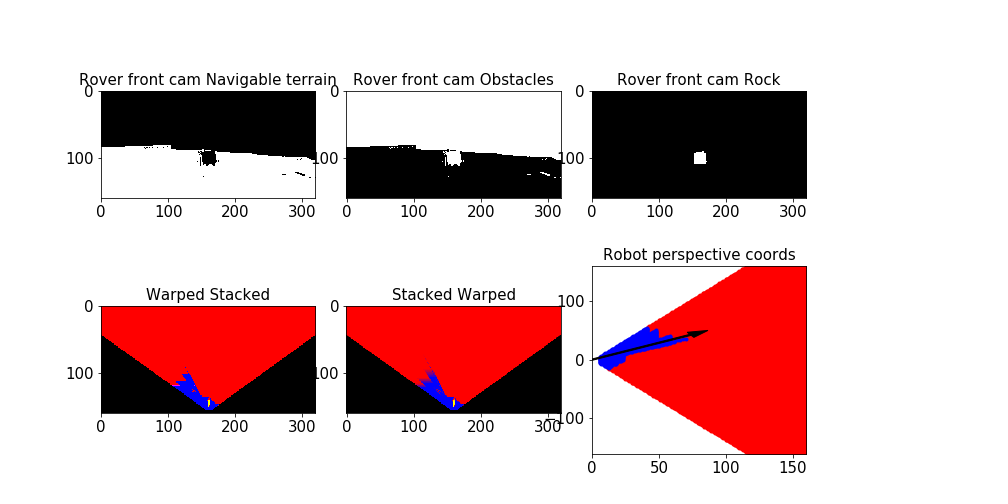

In [9]:
# Test code. 

# Grid image reading for calibration purposes

grid_img = mpimg.imread('../calibration_images/example_grid1.jpg')
print('Image data type is: ', grid_img.dtype)
print('')
print('Image range is: %i to %i' % (np.min(grid_img), np.max(grid_img)))
print('')


# Source and destination points

bottom_offset = 6.0
src_pts = np.float32([[12, 140], [118, 95], [200, 95], [300, 140]])
dst_pts = np.float32([[(grid_img.shape[1] / 2.0) - 5.0, grid_img.shape[0] - bottom_offset],
                     [(grid_img.shape[1] / 2.0) - 5.0, grid_img.shape[0] - bottom_offset - 10.0],
                     [(grid_img.shape[1] / 2.0) + 5.0, grid_img.shape[0] - bottom_offset - 10.0],
                     [(grid_img.shape[1] / 2.0) + 5.0, grid_img.shape[0] - bottom_offset]])


# Test image.

img = mpimg.imread('../calibration_images/example_rock1.jpg')

rgb_thresh = (160, 160, 160)


# Thresholding for different detections
color_select_rock = detect_yellow(img)
color_select = color_thresh(img, rgb_thresh)
color_select_obstacles = cv2.subtract(color_thresh(img, (0, 0, 0)), color_select)

# Warping the above thresholded images
warped_color_select_obstacles = perspect_transform(color_select_obstacles, src_pts, dst_pts)
warped_color_select_rock = perspect_transform(color_select_rock, src_pts, dst_pts)
warped_color_select = perspect_transform(color_select, src_pts, dst_pts)

# Stacking so as to get that same left-corner image (intermediate analysis) that is projected during the autonumous
# run of the robot. I stack twice to check for the difference. Once to warp the
# thresholded images then stack, and the other, stack the thresholded images then warp
color_select_stacked = np.dstack((color_select_obstacles * 255, color_select_rock * 255, color_select * 255))
warped_color_select_stacked = np.dstack((warped_color_select_obstacles * 255, warped_color_select_rock * 255, warped_color_select * 255))
warped_img = perspect_transform(color_select_stacked, src_pts, dst_pts)


# to robot coordinate system conversion
rover_perspect_x, rover_perspect_y = rover_coords(warped_color_select)
rover_perspect_obstacles_x, rover_perspect_obstacles_y = rover_coords_obstacles(warped_color_select_obstacles)


# Extracting navigable angles
r, theta = cart2polar(rover_perspect_x, rover_perspect_y)
avg_angle = np.mean(theta)


arrow_length = 100
arrow_dx = arrow_length * np.cos(avg_angle)
arrow_dy = arrow_length * np.sin(avg_angle)


# Plotting of the different images converted above

f, (ax1, ax2) = plt.subplots(2, 3, figsize = (14, 7))
f.tight_layout()

ax1[0].imshow(color_select, 'gray')
ax1[0].set_title('Rover front cam Navigable terrain', fontsize = 15)
ax1[0].tick_params(labelsize = 15)

ax1[1].imshow(color_select_obstacles, cmap = 'gray')
ax1[1].set_title('Rover front cam Obstacles', fontsize = 15)
ax1[1].tick_params(labelsize = 15)

ax1[2].imshow(color_select_rock, cmap = 'gray')
ax1[2].set_title('Rover front cam Rock', fontsize = 15)
ax1[2].tick_params(labelsize = 15)

ax2[0].imshow(warped_color_select_stacked, cmap = 'gray')
ax2[0].set_title('Warped Stacked', fontsize = 15)
ax2[0].tick_params(labelsize = 15)

ax2[1].imshow(warped_img, cmap = 'gray')
ax2[1].set_title('Stacked Warped', fontsize = 15)
ax2[1].tick_params(labelsize = 15)

ax2[2].plot(rover_perspect_obstacles_x, rover_perspect_obstacles_y, '.', color = 'red')
ax2[2].plot(rover_perspect_x, rover_perspect_y, '.', color = 'blue')
ax2[2].set_title('Robot perspective coords', fontsize= 15)
ax2[2].set_xlim(0, img.shape[0])
ax2[2].set_ylim(-np.int(img.shape[1] / 2.0), np.int(img.shape[1] / 2.0))
ax2[2].tick_params(labelsize = 15)

ax2[2].arrow(0, 0, arrow_dx, arrow_dy, length_includes_head = 100,
             shape = 'full', color = 'black', zorder = 3, width = 2, head_width=10)

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)

<IPython.core.display.Javascript object>


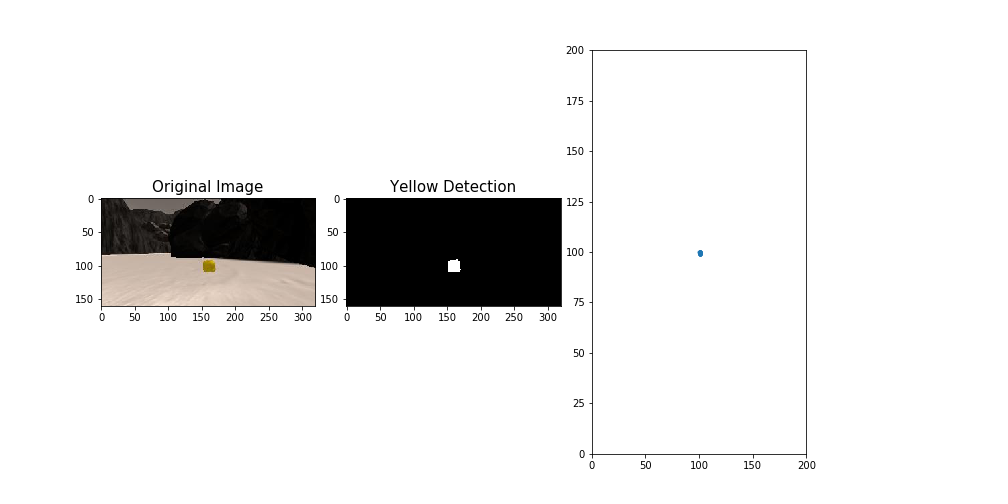

(0, 200)

In [10]:
# Sample rock detection and plot as world coordinates

example_rock = mpimg.imread('/home/abouseif/main/udacity/roboticsnd/robotics_term1/RoboND-Rover-Project/calibration_images/example_rock1.jpg')
rock_binary = detect_yellow(example_rock)
rock_world_x, rock_world_y= yellow_rock_world(example_rock, 100, 100, 1, 10, 200)




f , ax1 = plt.subplots(1, 3, figsize = (14, 7))
f.tight_layout()
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
ax1[0].imshow(example_rock)
ax1[0].set_title('Original Image', fontsize = 15)

ax1[1].imshow(rock_binary, cmap = 'gray')
ax1[1].set_title('Yellow Detection', fontsize = 15)

ax1[2].plot(rock_world_x, rock_world_y, '.')
ax1[2].set_xlim(0, 200)
ax1[2].set_ylim(0, 200)

In [11]:
# As also in the lectures, creating a test-video and a test object and applying the processing pipeline to see the results


df = pd.read_csv('/home/abouseif/Link to robotics_term1/RoboND-Rover-Project/test_dataset/robot_log.csv', delimiter = ';', decimal = '.')

csv_img_list = df['Path'].tolist()

ground_truth = mpimg.imread('/home/abouseif/Link to robotics_term1/RoboND-Rover-Project/calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth * 0, ground_truth * 255, ground_truth * 0)).astype(np.float)

class Databucket():
    def __init__(self):
        self.images = csv_img_list
        self.xpos = df['X_Position'].values
        self.ypos = df['Y_Position'].values
        self.yaw = df['Yaw'].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d
        

In [21]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    dst_size = 5
    bottom_offset = 6
    scale = 10
    
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[img.shape[1]/2 - dst_size, img.shape[0] - bottom_offset],
                  [img.shape[1]/2 + dst_size, img.shape[0] - bottom_offset],
                  [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - bottom_offset], 
                  [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - bottom_offset],
                  ])
    # 2) Apply perspective transform

    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    rgb_thresh = (160, 160, 160)
    
    
    color_select_rock = detect_yellow(img)
    color_select = color_thresh(img, rgb_thresh)
    # Here i subtract the navigable terrain from the whole image by using cv2.subtract to also account for
    # negative values (if there are any).
    color_select_obstacles = cv2.subtract(color_thresh(img, (0, 0, 0)), color_select)
    
    warped_color_select_obstacles = perspect_transform(color_select_obstacles, src_pts, dst_pts)
    warped_color_select_rock = perspect_transform(color_select_rock, src_pts, dst_pts)
    warped_color_select = perspect_transform(color_select, src_pts, dst_pts)

    # color_select_stacked = np.dstack((color_select_obstacles * 255, color_select_rock * 255, color_select * 255))
    warped_img = perspect_transform(color_select_stacked, src_pts, dst_pts)

    # 4) Convert thresholded image pixel values to rover-centric coords
    x_rover, y_rover = rover_coords(warped_color_select)
    x_world, y_world = rover2world(x_rover, y_rover, data.xpos[data.count], data.ypos[data.count], 
                                   data.yaw[data.count], 10, data.worldmap.shape[0])
    
    rock_x_world, rock_y_world = yellow_rock_world(img, data.xpos[data.count], data.ypos[data.count], 
                                                   data.yaw[data.count], scale, data.worldmap.shape[0])
    
    obstacles_rover_x, obstacles_rover_y = rover_coords_obstacles(warped_color_select_obstacles)
    obstacles_world_x, obstacles_world_y = rover2world(obstacles_rover_x, obstacles_rover_y, 
                                                       data.xpos[data.count], data.ypos[data.count], 
                                                       data.yaw[data.count], 10, data.worldmap.shape[0])
    
    
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
    
    
    data.worldmap[obstacles_world_y, obstacles_world_x, 0] += 1
    data.worldmap[y_world, x_world, 2] += 1
    data.worldmap[rock_y_world, rock_x_world, 1] +=1

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
        
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)
    
    warped_color_select_stacked = np.dstack((warped_color_select_obstacles * 255, 
                                             warped_color_select_rock * 255, warped_color_select * 255))
    
    output_image[img.shape[0]:-40, img.shape[1]:] = warped_color_select_stacked
    

        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../test_mapping.mp4
[MoviePy] Writing video ../test_mapping.mp4


100%|██████████| 283/283 [00:05<00:00, 54.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_mapping.mp4 

CPU times: user 5.11 s, sys: 92 ms, total: 5.2 s
Wall time: 5.47 s


In [14]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))